코드 생성

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [294]:
OV = 4
ms = 100 # message 한 bit 마다 20ms


# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4.
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [295]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.0000001

# 잡음의 크기 설정
num_samples = 1023 * ms * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))
imaginary_noise = np.random.normal(0, 1, num_samples) / (np.sqrt(2) * np.sqrt(OV))

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [296]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []
for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)
        
print(len(data))



5


Signal 생성

In [297]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq, signal_length, OV = 1.023e6*OV):
    delayed_seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    signal = delayed_seq * oversampled_signal[:signal_length] + complex_noise
    return signal
    

Replica 신호 생성

In [298]:
def generate_replica_signal(code_delay, doppler_freq, code_freq, svNumber, signal_length = 1023*OV ,OV = 1.023e6*OV ):
    ca_code = np.array(codes[svNumber])
    ca_code = [chip for chip in ca_code for _ in range(int(OV//1.023e6))]
    delayed_code = np.roll(ca_code, code_delay)
    
    t = np.arange(signal_length)
    code_phase = 2 * np.pi * code_freq * t / OV
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / OV))
    # oversampled_signal = np.exp(1j*(2*np.pi * (code_freq + doppler_freq) * t / OV))
    replica =  delayed_code * oversampled_signal[:signal_length]
    return replica
    

Acquisition

In [299]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, signal_length, OV):
    
    # 신호 1ms씩 쪼개기
    signal_div = [signal[i:i+(1023*OV)] for i in range(0,len(signal), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = generate_replica_signal(code_delay_range[0],doppler_freq,code_freq, svNumber)
        
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica, mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
    # 20ms 안에서 bit boundary(B) 값 탐색
    True_replica = generate_replica_signal(max_code_delay,max_doppler_freq, code_freq, svNumber)
    cor_lst = []
    phase  = []
    for i in range(ms):
        cor = correlate(signal_div[i], True_replica, mode = 'valid')
        cor_lst.append(np.max(cor)) #cor_lst 얘로 phase 계산
        phase.append(np.arctan2(np.imag(cor), np.real(cor))) #왜 arctan2를 썼을까
    print(*phase)
    phase_diff = []
    for i in range(1, ms):
        phase_diff.append((phase[i]-phase[i-1]))
    print(*phase_diff)  
    mean_phasediff = sum(phase_diff)/ms
    
    
    return max_code_delay, max_doppler_freq, cor_lst, phase, phase_diff, corr_matrix
    
    
    
    
            

Acquisition 실행

In [300]:
#bit boundary 찾아야 한다
#노이즈 좀더 크게


# Parameters
#B = rand.randint(0,20)  # Bit Boundary 무작위 설정 - bit boundary - 1ms안에서 맞추는거 (frame 동기화도 있음)
#F = rand.randint(0,1023) # 1ms code 내 delay 설정
B = 0
F = 0


code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (B*1023+F)*OV) # Range of code delay in chips (0 ~ 1023*B + F)

true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = rand.sample(range(-5000, 5000, 500), 1)[0]
#true_doppler_freq = 0


received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, 1023*20*(ms//20)*OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, phase, phase_diff, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,1023*20*(ms//20)*OV,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40)

print(corr_matrix)


----------------------------------------
Frame Sync completed.
Frame delay : 0.0
Estimated_Frequency Offset : 500.0
Max correlation : 388.4111273476827
----------------------------------------
[0.26766999] [-2.50893724] [1.25479304] [-1.49804485] [2.13254964] [-0.53016009] [3.05137077] [0.36065635] [-2.27944779] [1.36911823] [-1.33386607] [2.29706035] [-0.37992484] [-3.11384591] [0.51485993] [-2.17581708] [1.47888944] [-1.15380575] [2.40254854] [-0.22772876] [0.29877152] [-2.45006621] [1.185933] [-1.55062991] [2.12797922] [-0.53956116] [3.08641996] [0.41416652] [-2.27511851] [1.33945015] [-1.37971328] [2.30616725] [-0.42398651] [-3.10080296] [0.54819538] [-2.07794114] [1.56204151] [-1.18944118] [2.47933812] [-0.23742907] [0.30272755] [-2.43966699] [1.20955332] [-1.51349454] [2.16205064] [-0.56199484] [3.08350029] [0.31652423] [-2.17159408] [1.2857132] [-1.28359975] [2.24619516] [-0.3708532] [-3.06414241] [0.50681663] [-2.11298118] [1.37729961] [-1.17538507] [2.39741986] [-0.25133916] [

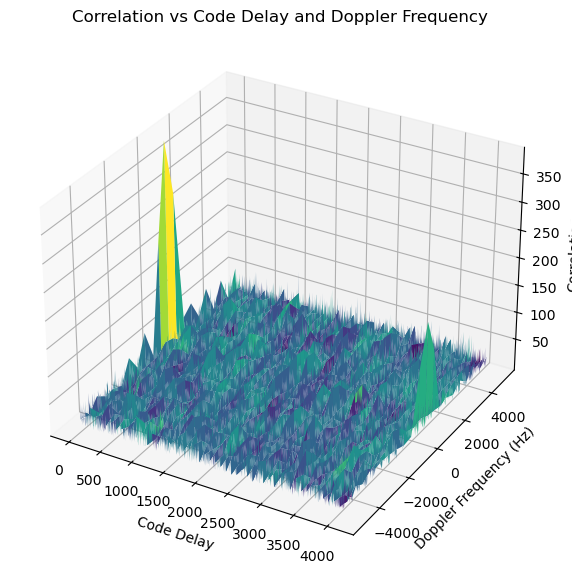

In [301]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



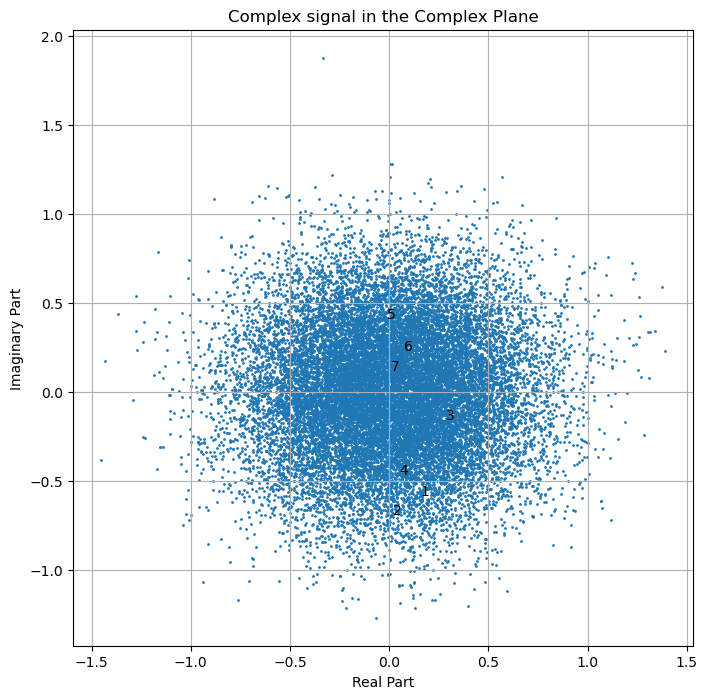

In [302]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(received_signal[:1023*20]), np.imag(received_signal[:1023*20]), s=1)

for i, txt in enumerate(range(1, 0 + 8)):
    plt.annotate(f'{txt}', (np.real(received_signal[i]), np.imag(received_signal[i])))
    
plt.title("Complex signal in the Complex Plane")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

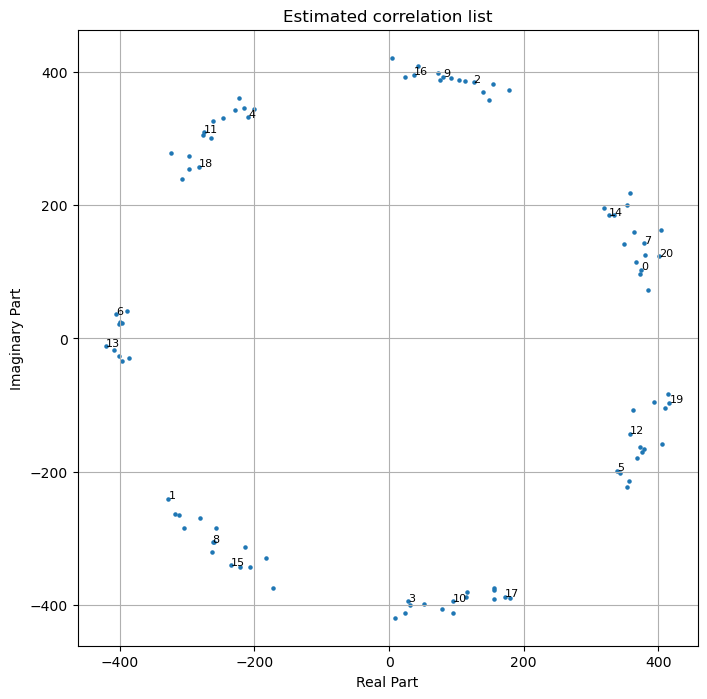

In [303]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst), np.imag(cor_lst), s=5)

for i, txt in enumerate(range(0, 0 + 21)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

get fine Frequency: 왜해..?

In [304]:
#input 재정의: 
#kLargest = doppler주파수estimation한걸로 넣
#data = received_signal로 넣ㅇㅇ
#GPS_fs = 샘플링 주파수 넣ㅇㅇ(아마?)


def GetFineFrequency(signal, kLargest, GPS_fs): # now passed in data class
    # Performs fine-frequency estimation. In this case, data will be a slice
    # of data (probably same length of data that was used in the circular
    # cross-correlation)


    # Perform DFT on each of the ms of data (5 total), at kLargest frequency.
    # Uses variables from medium-frequency, so if they change, may need to re-create below.
    X = []
    PhaseAngle = []
    numMSmf = 1 # num ms for medium-frequency estimation
    Nmf = int(np.ceil(numMSmf*0.001*GPS_fs))  # num of samples to use for medium-frequency estimation (and DFT)
    # Create sampled time array for DFT
    Ts = 1/GPS_fs
    nTs = np.linspace(0,Ts*(Nmf + 1),Nmf,endpoint=False)
    
    for i in range(0,20):
        X.append(sum(signal[i*1023:(i+1)*1023]*np.exp(-2*np.pi*1j*kLargest*nTs)))
        PhaseAngle.append(np.arctan(np.imag(X[i])/np.real(X[i])))
        print("Magnitude: %f" %X[i])
        print("Phase Angle: %f" %PhaseAngle[i])

    # Get difference angles
    PhaseDiff = []
    for i in range(1,20):
        PhaseDiff.append(PhaseAngle[i]-PhaseAngle[i-1])
        print("Phase difference %d, is: %f"%((i-1),PhaseDiff[i-1]))


    PhaseThreshold = (2.3*np.pi)/5
    for (i,curPhaseDiff) in enumerate(PhaseDiff):
        if np.abs(curPhaseDiff) > PhaseThreshold:
            curPhaseDiff = PhaseDiff[i] - 2*np.pi
            if np.abs(curPhaseDiff) > PhaseThreshold:
                curPhaseDiff = PhaseDiff[i] + 2*np.pi
                if np.abs(curPhaseDiff) > (2.2*np.pi)/5:
                    curPhaseDiff = PhaseDiff[i] - np.pi
                    if np.abs(curPhaseDiff) > PhaseThreshold:
                        curPhaseDiff = PhaseDiff[i] - 3*np.pi
                        if np.abs(curPhaseDiff) > PhaseThreshold:
                            curPhaseDiff = PhaseDiff[i] + np.pi
        PhaseDiff[i] = curPhaseDiff
    fList = (np.array(PhaseDiff)/(2*np.pi*0.001))
    print(fList)
    print()
    print(np.mean(fList))

    FineFrequencyEst = (np.mean(fList)) #각 데이터 슬라이스에서 계산된 위상 차이에 대한 주파수 변화율
    #return FineFrequencyEst
    return PhaseAngle, PhaseDiff



In [305]:
kLargest = estimated_doppler_freq
GPS_fs= code_freq
print(len(data))
#FineFrequencyEst = GetFineFrequency(received_signal, kLargest, GPS_fs)
PhaseAngle, PhaseDiff = GetFineFrequency(received_signal, kLargest, GPS_fs)

print()
print(PhaseAngle)
print()
print(PhaseDiff)

#print(FineFrequencyEst + estimated_doppler_freq)
#print("frequency 추정 완료")



5
Magnitude: -7.600740
Phase Angle: 1.157996
Magnitude: 10.632338
Phase Angle: 0.512401
Magnitude: -6.700961
Phase Angle: 0.849890
Magnitude: 1.285084
Phase Angle: -1.380358
Magnitude: -12.221604
Phase Angle: -0.932311
Magnitude: -8.534280
Phase Angle: -0.479519
Magnitude: -5.997413
Phase Angle: -0.954986
Magnitude: 26.850359
Phase Angle: 0.242150
Magnitude: -14.555719
Phase Angle: -0.530705
Magnitude: 12.782425
Phase Angle: -0.930422
Magnitude: 4.828903
Phase Angle: -1.083060
Magnitude: -2.900132
Phase Angle: -1.283146
Magnitude: 14.123985
Phase Angle: 0.911849
Magnitude: 10.041109
Phase Angle: 0.909921
Magnitude: 3.297135
Phase Angle: 1.039850
Magnitude: 7.633274
Phase Angle: 0.351755
Magnitude: -16.248433
Phase Angle: -0.383559
Magnitude: -9.842728
Phase Angle: -1.084217
Magnitude: 11.799714
Phase Angle: -1.196723
Magnitude: -12.985246
Phase Angle: 0.556810
Phase difference 0, is: -0.645596
Phase difference 1, is: 0.337490
Phase difference 2, is: -2.230249
Phase difference 3, is: 0.

C:\Users\siljn\AppData\Local\Temp\ipykernel_13604\2249050510.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  print("Magnitude: %f" %X[i])


C:\Users\siljn\AppData\Local\Temp\ipykernel_13604\213851146.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_signal = abs(signal) * cmath.rect(1, cumulative_phase)


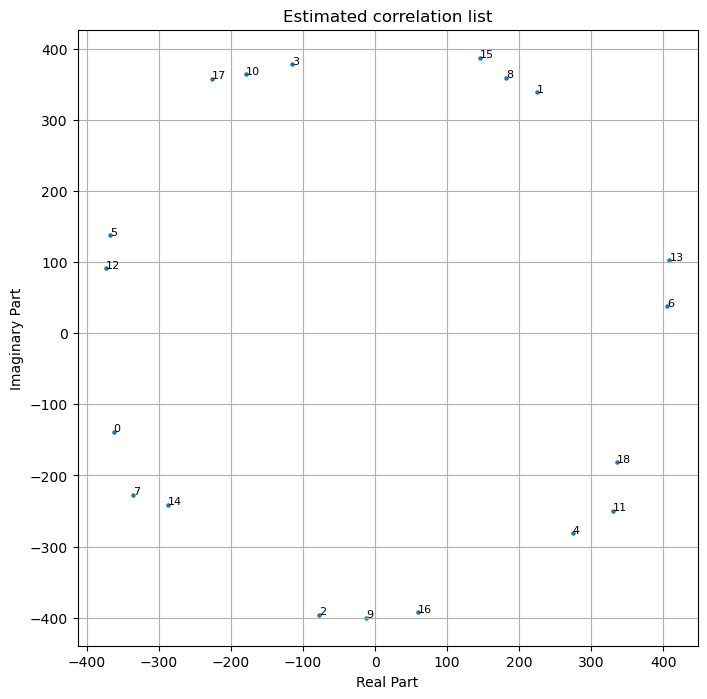

In [306]:
import cmath

# 주어진 복소수 신호
signals = cor_lst[:19]  # 신호들의 리스트
phases = phase_diff  # 각 phase들의 리스트

# 누적된 phase를 더해줄 신호들의 리스트
new_signals = []

# 각 신호에 누적된 phase를 더해주기
cumulative_phase = 0
for i in range(len(signals)):
    signal = signals[i]
    phase = phases[i]
    cumulative_phase += phase
    new_signal = abs(signal) * cmath.rect(1, cumulative_phase)
    new_signals.append(new_signal)


plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_signals), np.imag(new_signals), s=5)

for i, txt in enumerate(range(0, 0 + 19)):
    plt.annotate(f'{txt}', (np.real(new_signals[i]), np.imag(new_signals[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

acquisition result

[ 0.15966355-0.583644j    0.01971648-0.68755847j  0.28465682-0.15551675j
 ... -0.27343341+0.19367721j -0.33823208-0.09064893j
  0.44583657+0.05307484j]


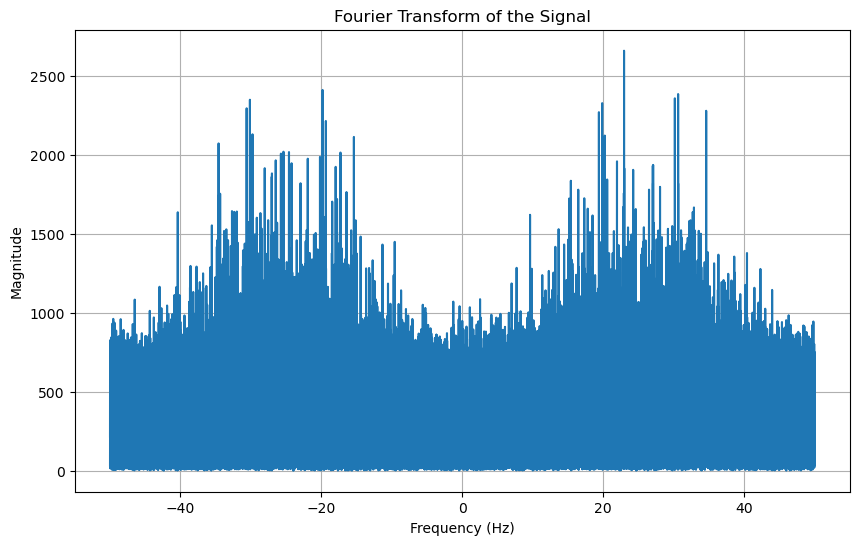

In [307]:
#전
print(received_signal)

# 주어진 신호에 대한 푸리에 변환 계산
fft_result = np.fft.fft(received_signal)

# 주파수 영역의 값을 생성
N = len(received_signal)
frequencies = np.fft.fftfreq(N, d=0.01)  # 주파수 축 생성

# 푸리에 변환 결과를 F 축에 대해 플롯
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))  # 푸리에 변환 결과의 절대값 플롯
plt.title('Fourier Transform of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

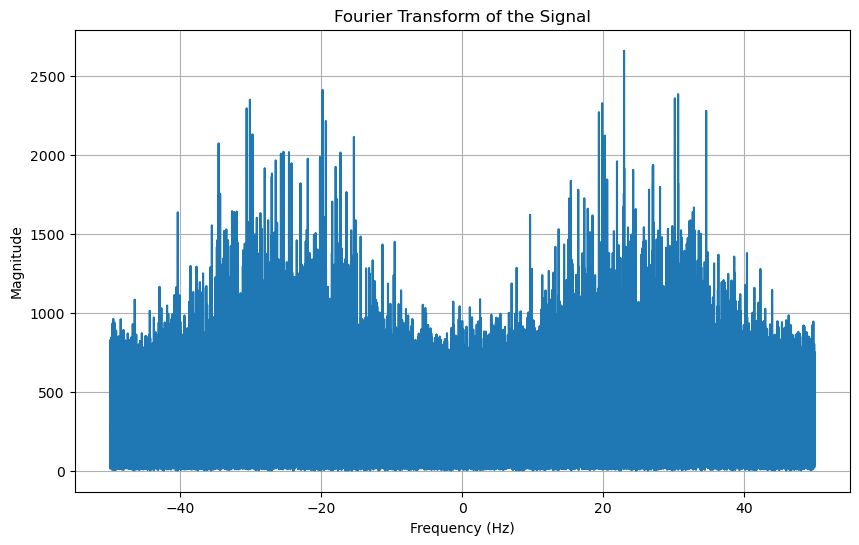

In [308]:
t = np.arange(len(received_signal))
#후
received_signal = received_signal*np.exp(-1j*estimated_doppler_freq*2*np.pi*t)*(np.exp(1j*estimated_code_delay*2*np.pi*t))




# 주어진 신호에 대한 푸리에 변환 계산
fft_result = np.fft.fft(received_signal)

# 주파수 영역의 값을 생성
N = len(received_signal)
frequencies = np.fft.fftfreq(N, d=0.01)  # 주파수 축 생성

# 푸리에 변환 결과를 F 축에 대해 플롯
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))  # 푸리에 변환 결과의 절대값 플롯
plt.title('Fourier Transform of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

## 밑에는

## 작업중

## 병렬구조 만들기 (Demod, DLL 하기 전)

신호를 I, Q로 쪼갠 뒤 각각을 계산해야함

In [309]:
# Extract real and imaginary parts separately
def spliter(signal):
    return np.real(signal), np.imag(signal)

real_part, imaginary_part = spliter(received_signal)

cur_code_delay = estimated_code_delay

E = generate_replica_signal(cur_code_delay - (OV // 2), estimated_doppler_freq, code_freq, svNumber)
P = generate_replica_signal(cur_code_delay, estimated_doppler_freq, code_freq, svNumber)
L = generate_replica_signal(cur_code_delay + (OV // 2), estimated_doppler_freq, code_freq, svNumber)

Real_E, Imag_E = spliter(E)
Real_P, Imag_P = spliter(P)
Real_L, Imag_L = spliter(L)

signal_div_Real = [real_part[i:i+(1023*OV)] for i in range(0,len(real_part), 1023*OV)]
signal_div_Imaginary = [imaginary_part[i:i+(1023*OV)] for i in range(0,len(imaginary_part), 1023*OV)]

def I_and_D(signal, replica):
    correlation = []
    for lst in signal:
        cor = correlate(lst, replica,mode='valid')
        correlation.append(np.max(cor))
    return list(correlation)

I_E = I_and_D(signal_div_Real, Real_E)
Q_E = I_and_D(signal_div_Imaginary, Imag_E)
I_P = I_and_D(signal_div_Real, Real_P)
Q_P = I_and_D(signal_div_Imaginary, Imag_P)
I_L = I_and_D(signal_div_Real, Real_L)
Q_L = I_and_D(signal_div_Imaginary, Imag_L)


print(I_E)
print(Q_E)
print(I_P)
print(Q_P)
print(I_L)
print(Q_L)

[89.19625614249068, -90.73432646965611, 29.200096988895165, 10.69102694030319, -46.71676389593675, 84.99570301163423, -98.93150399053934, 96.79535506098198, -65.96042027819337, 13.272118937658242, 24.466926836308573, -61.337305436826924, 94.1982671462643, -101.91598827125767, 79.62366094885043, -47.07636401238171, 9.032227477828666, 32.65429464905685, -72.6770196477616, 112.14333699166478, 99.03154206889901, -81.5609894930784, 40.5444910628147, 12.199165527394621, -73.46032422247738, 91.5760734530298, -112.87268363407114, 96.07313390882423, -76.58435927222314, 3.946640193642235, 15.60147276853413, -60.54610926596217, 90.13880936412203, -113.34969147018553, 101.36450863610574, -47.86357611575608, 7.505496868329214, 32.95555155748851, -92.77581019455275, 114.52244126518833, 101.43206642598227, -92.72079694977371, 39.59840527955467, 4.174431805299655, -68.88317414458089, 109.31644911537121, -89.67977037741255, 106.40777787216757, -53.680892325365356, 35.55078132301964, 48.9273121663612, -

In [310]:
#incoming signal 받고
#NCO carrier generator에서 받아와서 sin, cos 곱해
#여기까지  signal * sin, signal * cos


#그거랑 PRN이랑 곱해(E,P,L)
#여기까지 signal*sin*PRN...


# Residual code/carrier phase
remCodePhase = 0.0

# define residual carrier phase
remCarrPhase  = 0.0

# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco = 0.0
oldCarrError = 0.0

dataPosition = 0
blksize = 0


carrFreq = -3363.8
fs = 1023*4*1000
codeLength = 1023
earlyLateSpacing = 0.5
chippingRate = 1023000
codeFreq = 1023000







In [311]:
# 91p
# Calculate filter coefficient values for code loop
def calculate_loop_coefficients(loop_noise_bandwidth, zeta, loop_gain, sum_int):
    """
    Calculates the loop coefficients tau1 and tau2.

    This process is discussed in sections 7.1-7.3 of Borre.

    Parameters:
    loop_noise_bandwidth (float): Loop noise bandwidth.
    zeta (float): Damping ratio.
    loop_gain (float): Loop gain.
    sum_int (float): Summation interval.

    Returns:
    tuple: Coefficient 1 (coeff1) and Coefficient 2 (coeff2).
    """
    # Solve for the natural frequency
    wn = loop_noise_bandwidth * 8 * zeta / (4 * zeta**2 + 1)

    # Solve for tau1 and tau2
    tau1 = loop_gain / (wn * wn)
    tau2 = (2.0 * zeta) / wn

    coeff1 = tau2 / tau1
    coeff2 = float(sum_int) / tau1

    return coeff1, coeff2


#91p참고 (loop_gain, sum_int는 모르겠다)
loop_noise_bandwidth = 20
zeta = 0.7
loop_gain = 1
sum_int = 1e-3
#coeffCode1, coeffCode2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
#coeffCar1, coeffCar2 = calculate_loop_coefficients(loop_noise_bandwidth,zeta,loop_gain,sum_int)
coeffCode1, coeffCode2 = 5.2972972972972965, 0.014317019722425127
coeffCar1, coeffCar2 = 264.86486486486484, 8.948137326515706

print(coeffCode1, coeffCode2)
print(coeffCar1, coeffCar2)

t_code = [item for item in t_code for _ in range(10)]

5.2972972972972965 0.014317019722425127
264.86486486486484 8.948137326515706


In [312]:

#Store the shift registers as a deque, so that deque.rotate() can be used.
from collections import deque  
import numpy as np

'''
GPS Gold Code generator. Initialized with the feedback taps for one satellite.
'''

#Feedback taps as defined in GPS spec
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]


def getCode(num, zero = False, samplesPerChip = 1, prn = 0):
    '''
    Returns a list of bits that form the Gold Code PRN of the designated satellite
    
    zero flag determines whether 0 or -1 is returned
    '''
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
        
    g = []

    for i in range(num):
        val = (g1[9] + g2[prn[0]] + g2[prn[1]]) % 2
        g.append(val)

        #Shift g1
        g1[9] = sum([g1[i] for i in g1tap]) % 2 
        g1.rotate()

        #Shift g2
        g2[9] = sum([g2[i] for i in g2tap]) % 2 
        g2.rotate()

    if(zero == False):
        #format GC to have -1 in place of 0
        for n,i in enumerate(g):
            if i==0:
                g[n]=-1
    
    if (samplesPerChip > 1 ):
        # Repeat each chip to match our ADC sample frequency
        gsamp = np.repeat(g, samplesPerChip)
        return gsamp
    return g

def getTrackingCode(sat):
    '''
    Returns a code ready to be used by Tracking.py
    '''
    code = np.array(getCode(1023, prn = sats[sat - 1]))

    # Need to add extra code chips to the ends so that it can 'slide'
    # back and forth during tracking.
    code = np.append(code,code[0])
    code = np.insert(code,0, code[len(code) - 2])
    return code


def getAcquisitionCode(sat, spc):
    '''
    Returns a code ready to be used by Acquisition.py
    '''
    return getCode(1023, samplesPerChip = spc, prn = sats[sat-1])



## Tracking loop test

In [313]:

import numpy as np
import matplotlib.pyplot as plt
import configparser



# code tracking loop parameters
oldCodeNco   = 0.0
oldCodeError = 0.0

# carrier/Costas loop parameters
oldCarrNco   = 0.0
oldCarrError = 0.0

acquiredCarrFreq = estimated_doppler_freq
chippingRate = code_freq #codeFreqBasis

dataPosition = 0
CACode = getTrackingCode(RN)

I_P_list = []

# Process the requested number of code periods (num of ms to process)
for i in range(0, ms):
    print("\n------- %2.1f percent complete --------"%((i/ms)*100), end = '\r')
    # Find PLL error and update carrier NCO
    # Implement carrier loop discriminator (phase detector)

    # Update the phasestep based on code freq (variable) and
    # sampling frequency (fixed)
    codePhaseStep = np.real(codeFreq / fs) #맨아래에서 업데이트 시킨 codeFreq여기서 사용-LOOP
    
    
    #print("Old blksize: %d"%blksize)
    blksize = int(np.ceil((codeLength-remCodePhase) / codePhaseStep))
    #print("New blksize: %d"%blksize)
    #print("Old remCodePhase: %f" %remCodePhase)

    # Read in the appropriate number of samples to process this
    # iteration
    rawSignal = received_signal[dataPosition:dataPosition+blksize]
    dataPosition = dataPosition + blksize


    
    # Generate Early CA Code.
    tStart = remCodePhase - earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep - earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    earlyCode = CACode[tcode2]




    # Generate Late CA Code.
    tStart = remCodePhase + earlyLateSpacing
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep + earlyLateSpacing
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    lateCode = CACode[tcode2]


    # Generate Prompt CA Code.
    tStart = remCodePhase
    tStep = codePhaseStep
    tEnd = ((blksize-1)*codePhaseStep+remCodePhase) + codePhaseStep
    tcode = np.linspace(tStart,tEnd,blksize,endpoint=False)
    tcode2 = (np.ceil(tcode)).astype(int)
    promptCode = CACode[tcode2]

    
    
    # Figure out remaining code phase (uses tcode from Prompt CA Code generation):
    remCodePhase = (t_code[blksize-1]) - 1023.00   #t_code: 10230
    if abs(remCodePhase) > codePhaseStep:
        remCodePhase = np.sin(remCodePhase)*codePhaseStep
    else:
        remCodePhase = 0


    # Generate the carrier frequency to mix the signal to baseband
    time = np.array(range(0,blksize+1))/fs
    
    #print("Length of time array for cos and sin: %d" %len(time))
    # Get the argument to sin/cos functions
    trigarg = ((carrFreq * 2.0 * np.pi) * time) + remCarrPhase
    
    # Carry the leftover phase to the next argument by looking at the last element
    #remCarrPhase = trigarg[blksize] % (2 * np.pi)
    remCarrPhase_real = trigarg[blksize-1].real % (2 * np.pi)
    remCarrPhase_imag = trigarg[blksize-1].imag % (2 * np.pi)
    remCarrPhase = remCarrPhase_real + 1j * remCarrPhase_imag


    # Finally compute the signal to mix the collected data to baseband
    carrCos = np.cos(trigarg[0:blksize])
    carrSin = np.sin(trigarg[0:blksize])
    
    # First mix to baseband
    #print(len(carrCos), len(rawSignal))
    qBasebandSignal = carrCos * rawSignal #38192, 30026
    iBasebandSignal = carrSin * rawSignal
    
    # Now get early, late, and prompt values for each
    I_E = np.sum(earlyCode  * iBasebandSignal) #1023, 38192
    Q_E = np.sum(earlyCode  * qBasebandSignal)
    I_P = np.sum(promptCode * iBasebandSignal)
    Q_P = np.sum(promptCode * qBasebandSignal)
    I_L = np.sum(lateCode   * iBasebandSignal)
    Q_L = np.sum(lateCode   * qBasebandSignal)
    
    I_P_list.append(I_P + Q_P)


    carrError = np.arctan(Q_P / I_P) / (2.0 * np.pi)
    #print(Q_P[i])
    
    # Implement carrier loop filter and generate NCO command
    carrNco = oldCarrNco + coeffCar1 * (carrError - oldCarrError) + carrError * coeffCar2
    oldCarrNco   = carrNco
    oldCarrError = carrError

    # Modify carrier freq based on NCO command
    carrFreq = acquiredCarrFreq + carrNco





    # Find DLL error and update code NCO -------------------------------------
    codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) /\
                            (np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))
    
    # Implement code loop filter and generate NCO command
    codeNco = oldCodeNco + coeffCode1 * (codeError - oldCodeError) + codeError * coeffCode2
    oldCodeNco   = codeNco
    oldCodeError = codeError
    
    # Modify code freq based on NCO command
    codeFreq = chippingRate - codeNco





#print(codeNco)
#print(codeFreq)
#print(codeError)
#print(carrError)


------- 0.0 percent complete --------
------- 1.0 percent complete --------
------- 2.0 percent complete --------
------- 3.0 percent complete --------
------- 4.0 percent complete --------
------- 5.0 percent complete --------
------- 6.0 percent complete --------
------- 7.0 percent complete --------
------- 8.0 percent complete --------
------- 9.0 percent complete --------
------- 10.0 percent complete --------
------- 11.0 percent complete --------
------- 12.0 percent complete --------
------- 13.0 percent complete --------
------- 14.0 percent complete --------
------- 15.0 percent complete --------
------- 16.0 percent complete --------
------- 17.0 percent complete --------
------- 18.0 percent complete --------
------- 19.0 percent complete --------
------- 20.0 percent complete --------
------- 21.0 percent complete --------
------- 22.0 percent complete --------
------- 23.0 percent complete --------
------- 24.0 percent complete --------
------- 25.0 percent complete ----

Demodulation

In [314]:
Prompt = []
for i in range(len(I_P_list)):
    if I_P_list[i] > 0:
        Prompt.append(1)
    else:
        Prompt.append(-1)

print(len(data))
print('data :', *data, sep = " ",)

print(len(Prompt))
print('est :', *Prompt, sep = " ")
# 리스트를 20개씩 묶기
grouped_lists = [Prompt[i:i+20] for i in range(0, len(Prompt), 20)]

# 각 그룹의 평균을 계산하고, 1 또는 -1로 변환하여 새로운 리스트 생성
result_lists = []
for group in grouped_lists:
    avg = sum(group) / len(group)
    result_lists.append(1 if avg > 0 else -1) 

# 결과 출력
print("\n\nresult", result_lists)



5
data : 1 -1 1 -1 1
100
est : 1 1 -1 -1 1 1 -1 -1 1 -1 -1 1 1 -1 -1 -1 1 1 1 1 -1 -1 -1 -1 -1 1 -1 -1 1 -1 1 1 1 1 1 1 -1 -1 1 -1 -1 -1 -1 1 1 -1 -1 -1 -1 -1 -1 1 -1 1 1 -1 1 1 1 -1 1 1 1 -1 1 1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 1 1 -1 -1 -1 1 1 1 -1 -1 -1 -1 -1 1 -1 1 1 -1 -1 1 1 1 -1


result [1, -1, -1, -1, -1]


결과 Plot